/Users/maciek_gangus/PycharmProjects/sentiment-analysis-shap/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8059047399377235
SHAP shape: (8671, 5000, 3)
===== Klasa: negative =====


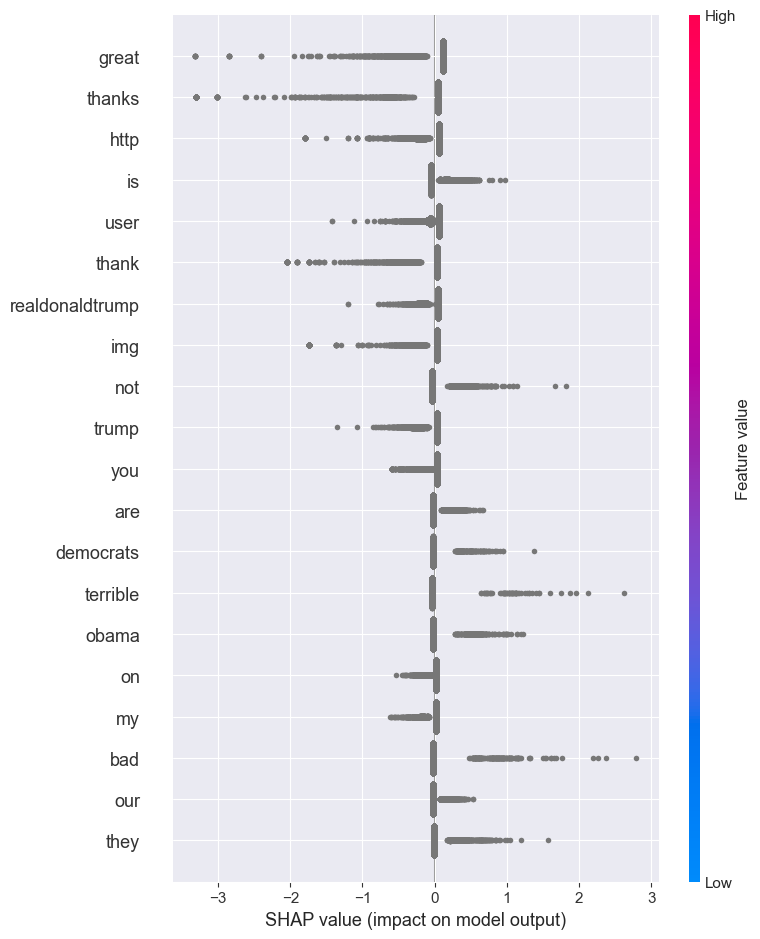

===== Klasa: neutral =====


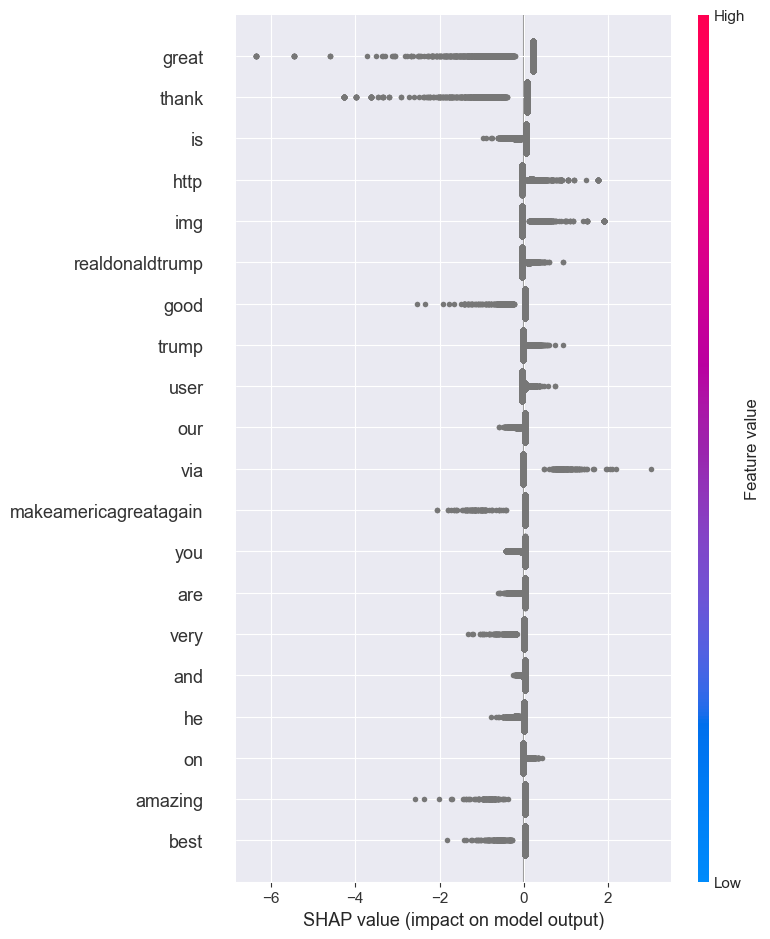

===== Klasa: positive =====


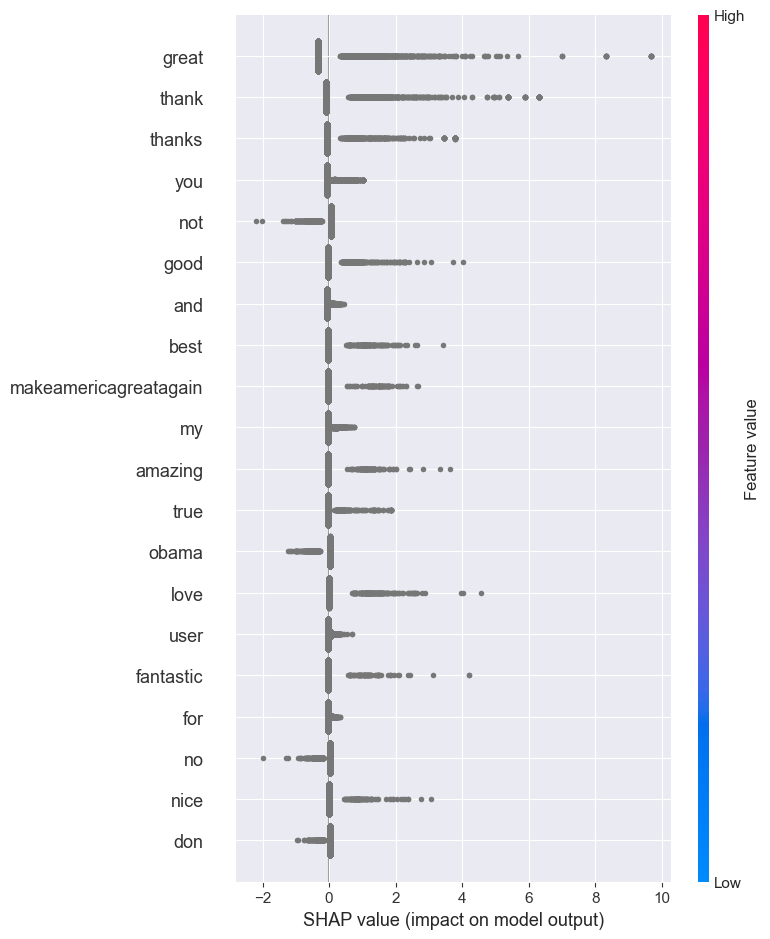

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import shap

# ========================================
# 1) Wczytanie danych
# ========================================

# Podmień ścieżkę na swoją!
df = pd.read_csv("../data/bert_sentiment.csv")  # kolumny: bert_clean, bert_sentiment_label

# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(
    df["bert_clean"],
    df["bert_sentiment_label"],
    test_size=0.2,
    random_state=42
)

# ========================================
# 2) Pipeline: TF-IDF + LogisticRegression (multi-class)
# ========================================

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'))
])

pipeline.fit(X_train, y_train)


print("Accuracy:", pipeline.score(X_train, y_train))
print("Accuracy:", pipeline.score(X_test, y_test))

# ========================================
# 3) SHAP - LinearExplainer dla multi-class
# ========================================

# Przekształć dane tekstowe do TF-IDF
X_train_tfidf = pipeline.named_steps['tfidf'].transform(X_train)
X_test_tfidf = pipeline.named_steps['tfidf'].transform(X_test)

# Utwórz explainer dla modelu liniowego
explainer = shap.LinearExplainer(
    pipeline.named_steps['clf'],
    X_train_tfidf
)

# SHAP values: shape (n_samples, n_features, n_classes)
shap_values = explainer(X_test_tfidf)

print("SHAP shape:", shap_values.values.shape)

# ========================================
# 4) Rysuj beeswarm plot (summary_plot) dla każdej klasy
# ========================================

# Nazwy cech
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
class_names = pipeline.named_steps['clf'].classes_

# Dla każdej klasy
for i, class_name in enumerate(class_names):
    print(f"===== Klasa: {class_name} =====")
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test_tfidf,
        feature_names=feature_names,
        plot_type='dot',   # domyślny beeswarm
        show=True
    )
